
# 1. Environment Setup & Data Ingestion
Initializing the research environment and loading the cleaned WHL 2025 base dataset.

Primary focus: Identifying game entities and outcomes for aggregation.

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# Load dataset
df = pd.DataFrame(pd.read_excel('datasci/whl_2025.xlsx'))
df.head()

,game_id,record_id,home_team,away_team,went_ot,home_off_line,home_def_pairing,away_off_line,away_def_pairing,home_goalie,...,home_goals,away_assists,away_shots,away_xg,away_max_xg,away_goals,home_penalties_committed,home_penalty_minutes,away_penalties_committed,away_penalty_minutes
0,game_1,record_1,thailand,pakistan,0,PP_kill_dwn,PP_kill_dwn,PP_up,PP_up,player_id_142,...,0,2,9,1.4645,0.2166,1,7,14,1,2
1,game_1,record_2,thailand,pakistan,0,second_off,second_def,second_off,second_def,player_id_142,...,0,2,1,0.0928,0.0928,1,0,0,0,0
2,game_1,record_3,thailand,pakistan,0,first_off,second_def,second_off,second_def,player_id_142,...,0,0,2,0.1880,0.0940,0,0,0,0,0
3,game_1,record_4,thailand,pakistan,0,second_off,first_def,second_off,first_def,player_id_142,...,0,0,1,0.0727,0.0727,0,0,0,0,0
4,game_1,record_5,thailand,pakistan,0,second_off,second_def,first_off,second_def,player_id_142,...,0,2,1,0.0769,0.0769,1,0,0,0,0


# 2. Multi-Level Data Aggregation
Transforming raw event data into game-specific metrics and normalizing

 'Home' and 'Away' statistics into a unified 'Team-Season' view.

In [28]:
'''
IDENTIFIERS:
- game_id
- record_id

ENTITIES:
- home_team
- away_team
- home_goalie
- away_goalie

CONTEXT:
- home_off_line
- away_off_line
- home_def_pairing
- away_def_pairing
- went_ot

OUTCOMES:
- home_goals
- away_goals
- home_shots
- away_shots
- home_penalties_committed
- away_penalties_committed

DERIVED METRICS:
- home_xg
- away_xg
- home_max_xg
- away_max_xg
'''

'\nIDENTIFIERS:\n- game_id\n- record_id\n\nENTITIES:\n- home_team\n- away_team\n- home_goalie\n- away_goalie\n\nCONTEXT:\n- home_off_line\n- away_off_line\n- home_def_pairing\n- away_def_pairing\n- went_ot\n\nOUTCOMES:\n- home_goals\n- away_goals\n- home_shots\n- away_shots\n- home_penalties_committed\n- away_penalties_committed\n\nDERIVED METRICS:\n- home_xg\n- away_xg\n- home_max_xg\n- away_max_xg\n'

# 2. Multi-Level Data Aggregation
Transforming raw event data into game-specific metrics and normalizing

 'Home' and 'Away' statistics into a unified 'Team-Season' view.

In [29]:
sum_cols = [
    "home_goals", "away_goals", "home_shots", "away_shots",
    "home_xg", "away_xg", "home_assists", "away_assists",
    "home_penalties_committed", "away_penalties_committed",
    "home_penalty_minutes", "away_penalty_minutes"
]
first_cols = ["home_team", "away_team", "went_ot"]

agg_dict = {col: "sum" for col in sum_cols}
agg_dict.update({col: "first" for col in first_cols})

games = df.groupby("game_id", as_index=False).agg(agg_dict)

# Feature Engineering: Goal and Shot Differentials
games["home_score"] = games["home_goals"]
games["away_score"] = games["away_goals"]
games["goal_diff"] = games["home_score"] - games["away_score"]
games["total_goals"] = games["home_score"] + games["away_score"]
games["shot_diff"] = games["home_shots"] - games["away_shots"]
games["total_shots"] = games["home_shots"] + games["away_shots"]

# Split and Concat for Team-Specific Analysis
home_games = games.copy().assign(is_home=1)
home_games.rename(columns={'home_team': 'team', 'away_team': 'opponent', 'home_score': 'goals_for', 'away_score': 'goals_against'}, inplace=True)

away_games = games.copy().assign(is_home=0)
away_games.rename(columns={'away_team': 'team', 'home_team': 'opponent', 'away_score': 'goals_for', 'home_score': 'goals_against'}, inplace=True)

team_games = pd.concat([home_games, away_games], ignore_index=True)

In [30]:
away_games = games.copy()

away_games["team"] = away_games["away_team"]
away_games["opponent"] = away_games["home_team"]

away_games["goals_for"] = away_games["away_score"]
away_games["goals_against"] = away_games["home_score"]

away_games["shots_for"] = away_games["away_shots"]
away_games["shots_against"] = away_games["home_shots"]

away_games["xg_for"] = away_games["away_xg"]
away_games["xg_against"] = away_games["home_xg"]

away_games["is_home"] = 0

# 3. Performance Volatility & OT Resilience
Isolating 'Regulation Purity' to filter out overtime luck.

Identifying 'Paper Tigers' (OT-reliant) vs 'Resilient Underdogs' (High OT losses).

In [31]:
# 1. Create Home Perspective with standardized names
home_games = games.copy().assign(is_home=1)
home_games.rename(columns={
    'home_team': 'team',
    'home_shots': 'shots_for',
    'away_shots': 'shots_against',
    'goal_diff': 'goal_diff' # already exists from games
}, inplace=True)

# 2. Create Away Perspective with standardized names
away_games = games.copy().assign(is_home=0)
away_games.rename(columns={
    'away_team': 'team',
    'away_shots': 'shots_for',
    'home_shots': 'shots_against'
}, inplace=True)
# For Away, goal_diff must be inverted (if home lost 2-5, away won +3)
away_games['goal_diff'] = games['away_goals'] - games['home_goals']

# 3. Combine
team_games = pd.concat([home_games, away_games], ignore_index=True)

# 4. Win/Loss Logic (This will now work)
team_games["reg_win"] = ((team_games["goal_diff"] > 0) & (team_games["went_ot"] == 0)).astype(int)
team_games["ot_win"] = ((team_games["goal_diff"] > 0) & (team_games["went_ot"] == 1)).astype(int)
team_games["ot_loss"] = ((team_games["goal_diff"] < 0) & (team_games["went_ot"] == 1)).astype(int)
team_games["reg_loss"] = ((team_games["goal_diff"] < 0) & (team_games["went_ot"] == 0)).astype(int)

# 5. Aggregation
team_season = team_games.groupby("team", as_index=False).agg(
    games_played=("team", "count"),
    reg_wins=("reg_win", "sum"),
    ot_wins=("ot_win", "sum"),
    ot_losses=("ot_loss", "sum"),
    reg_losses=("reg_loss", "sum"),
    total_ot_games=("went_ot", "sum"),
    shots_for=("shots_for", "sum"),
    shots_against=("shots_against", "sum")
)

# Resilience and Deception Metrics
team_season["ot_reliance_ratio"] = team_season["ot_wins"] / (team_season["reg_wins"] + team_season["ot_wins"] + 1e-6)
team_season["resilience_factor"] = team_season["ot_losses"] / (team_season["reg_losses"] + team_season["ot_losses"] + 1e-6)
team_season["win_pct"] = (team_season["reg_wins"] + team_season["ot_wins"]) / team_season["games_played"]
team_season["reg_win_pct"] = team_season["reg_wins"] / team_season["games_played"]
team_season['deception_gap'] = team_season['win_pct'] - team_season['reg_win_pct']

# 4. Roster Depth & Defensive Identity
Analyzing 5-on-5 Purity (Top 2 Line average) and 'Goalie Factor' (xG vs Actual GA).

Classifying teams into strategic archetypes (e.g., One-Line Wonders).

In [32]:
# Offense: xG/60 per line
line_stats = df.groupby(['home_team', 'home_off_line']).agg(total_xg=('home_xg', 'sum'), total_toi=('toi', 'sum')).reset_index()
line_stats['xg_60'] = (line_stats['total_xg'] / line_stats['total_toi']) * 60
roster_pivot = line_stats.pivot(index='home_team', columns='home_off_line', values='xg_60')
roster_pivot['five_on_five_purity'] = (roster_pivot['first_off'] + roster_pivot['second_off']) / 2
roster_pivot['roster_stability_ratio'] = roster_pivot['first_off'] / (roster_pivot['second_off'] + 1e-6)

# Defense: xGA/60 and Goalie Factor
def_stats = df.groupby(['home_team', 'home_def_pairing']).agg(xg_against=('away_xg', 'sum'), goals_against=('away_goals', 'sum'), total_toi=('toi', 'sum')).reset_index()
def_stats['xGA_60'] = (def_stats['xg_against'] / def_stats['total_toi']) * 60
def_stats['actual_GA_60'] = (def_stats['goals_against'] / def_stats['total_toi']) * 60
def_stats['goalie_factor'] = def_stats['actual_GA_60'] - def_stats['xGA_60']

# 5. Visualizing Team Archetypes
 Scatter plot mapping OT Resilience against OT Reliance.

 Quadrants identify 'Resilient Underdogs' vs 'Paper Tigers'.

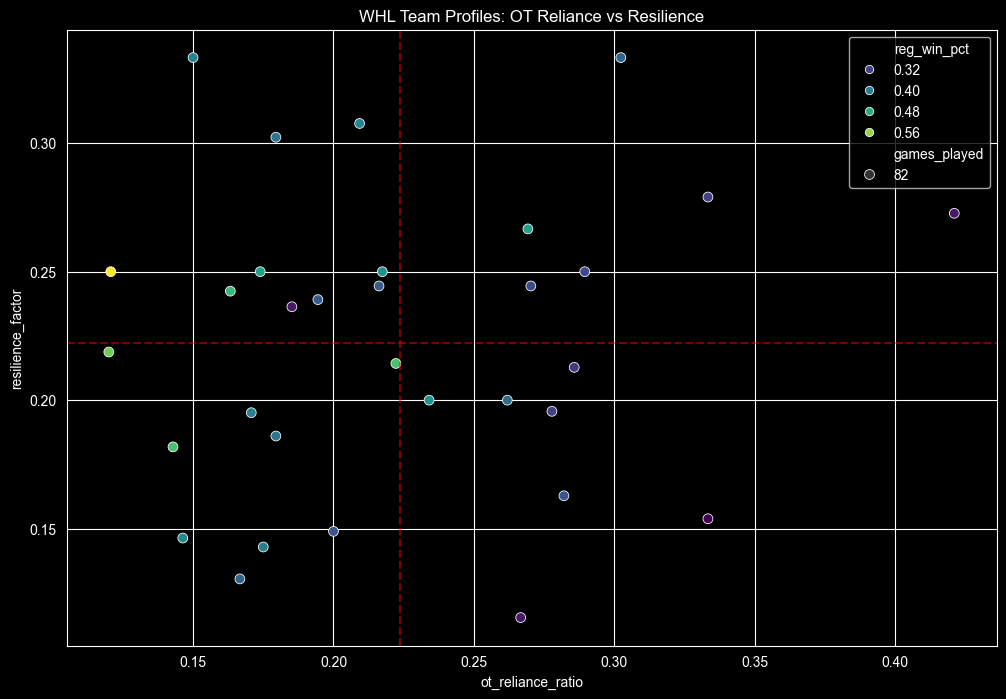

In [33]:
plt.figure(figsize=(12, 8))
plot = sns.scatterplot(data=team_season, x='ot_reliance_ratio', y='resilience_factor', hue='reg_win_pct', size='games_played', palette='viridis', sizes=(50, 400))

# Mean-line Quadrants
plt.axvline(team_season['ot_reliance_ratio'].mean(), color='red', linestyle='--', alpha=0.5)
plt.axhline(team_season['resilience_factor'].mean(), color='red', linestyle='--', alpha=0.5)

plt.title("WHL Team Profiles: OT Reliance vs Resilience")
plt.show()

# 7. Defensive Feature Engineering: Goalie & System Identity
Quantifying defensive efficiency by analyzing 'first_def' pairings.

Calculating the 'Goalie Factor' (Actual GA/60 - Expected GA/60) to identify
'Goalie Heroes' vs 'Leaky Systems'.

In [39]:
# 1. Aggregate Defensive Data
def_stats = df.groupby(['home_team', 'home_def_pairing']).agg(
    xg_against = ('away_xg', 'sum'),
    goals_against = ('away_goals', 'sum'),
    total_toi = ('toi', 'sum')
).reset_index()

# 2. Calculate Normalized Rates & Goalie Factor
def_stats['xGA_60'] = (def_stats['xg_against'] / def_stats['total_toi']) * 60
def_stats['actual_GA_60'] = (def_stats['goals_against'] / def_stats['total_toi']) * 60
def_stats['goalie_factor'] = def_stats['actual_GA_60'] - def_stats['xGA_60']

# 3. Labeling Logic
shutdown_unit = def_stats[def_stats['home_def_pairing'] == 'first_def'].set_index('home_team')
median_xGA = shutdown_unit['xGA_60'].median()

def classify_goalie_performance(row):
    is_steel_wall = row['xGA_60'] < median_xGA
    if row['goalie_factor'] < -0.2: goalie_label = "Goalie Hero"
    elif row['goalie_factor'] > 0.2: goalie_label = "Goalie Vulnerable"
    else: goalie_label = "Standard Support"
    return f"{'Steel Wall' if is_steel_wall else 'Leaky System'} ({goalie_label})"

shutdown_unit['def_identity'] = shutdown_unit.apply(classify_goalie_performance, axis=1)

# 6. The Master Feature Matrix (Team DNA)

Synthesis of Offensive, Defensive, and Special Teams identities into a single analytical core.

In [41]:
# --- FIX FOR SECTION 6 KEYERROR ---

# 1. Generate the missing 'off_identity' column
median_purity = roster_pivot['five_on_five_purity'].median()

def label_offense(row):
    # Logic based on your xG production and roster stability
    if row['five_on_five_purity'] > median_purity:
        return "High-Octane" if row['roster_stability_ratio'] < 1.5 else "Top-Heavy Juggernaut"
    return "Gritty Depth" if row['roster_stability_ratio'] < 1.5 else "One-Line Wonder"

# Apply it specifically to roster_pivot so it exists for the join
roster_pivot['off_identity'] = roster_pivot.apply(label_offense, axis=1)

# 2. Now perform the join (This will no longer throw a KeyError)
team_features_df = roster_pivot[['off_identity', 'five_on_five_purity']].join(
    shutdown_unit[['def_identity', 'xGA_60', 'goalie_factor']],
    how='inner'
)

# 3. Create the profile string
team_features_df['team_profile'] = team_features_df['off_identity'] + " | " + team_features_df['def_identity']

# 4. Success display
display(team_features_df.sort_values('five_on_five_purity', ascending=False))
team_features_df = roster_pivot[['off_identity', 'five_on_five_purity']].join(
    shutdown_unit[['def_identity', 'xGA_60', 'goalie_factor']]
)
team_features_df['team_profile'] = team_features_df['off_identity'] + " | " + team_features_df['def_identity']

display(team_features_df.sort_values('five_on_five_purity', ascending=False))

,off_identity,five_on_five_purity,def_identity,xGA_60,goalie_factor,team_profile
home_team,,,,,,
thailand,High-Octane,0.049432,Leaky System (Standard Support),0.035900,-0.001311,High-Octane | Leaky System (Standard Support)
pakistan,High-Octane,0.048831,Steel Wall (Standard Support),0.032840,-0.006807,High-Octane | Steel Wall (Standard Support)
brazil,High-Octane,0.048609,Steel Wall (Standard Support),0.026801,0.007616,High-Octane | Steel Wall (Standard Support)
south_korea,High-Octane,0.047373,Steel Wall (Standard Support),0.032182,0.000464,High-Octane | Steel Wall (Standard Support)
serbia,High-Octane,0.046142,Leaky System (Standard Support),0.041343,-0.005977,High-Octane | Leaky System (Standard Support)
china,High-Octane,0.043955,Steel Wall (Standard Support),0.031977,0.004543,High-Octane | Steel Wall (Standard Support)
oman,High-Octane,0.043165,Steel Wall (Standard Support),0.032021,0.012200,High-Octane | Steel Wall (Standard Support)
uk,High-Octane,0.042958,Leaky System (Standard Support),0.038415,-0.008084,High-Octane | Leaky System (Standard Support)
usa,High-Octane,0.042417,Leaky System (Standard Support),0.043740,0.008802,High-Octane | Leaky System (Standard Support)


,off_identity,five_on_five_purity,def_identity,xGA_60,goalie_factor,team_profile
home_team,,,,,,
thailand,High-Octane,0.049432,Leaky System (Standard Support),0.035900,-0.001311,High-Octane | Leaky System (Standard Support)
pakistan,High-Octane,0.048831,Steel Wall (Standard Support),0.032840,-0.006807,High-Octane | Steel Wall (Standard Support)
brazil,High-Octane,0.048609,Steel Wall (Standard Support),0.026801,0.007616,High-Octane | Steel Wall (Standard Support)
south_korea,High-Octane,0.047373,Steel Wall (Standard Support),0.032182,0.000464,High-Octane | Steel Wall (Standard Support)
serbia,High-Octane,0.046142,Leaky System (Standard Support),0.041343,-0.005977,High-Octane | Leaky System (Standard Support)
china,High-Octane,0.043955,Steel Wall (Standard Support),0.031977,0.004543,High-Octane | Steel Wall (Standard Support)
oman,High-Octane,0.043165,Steel Wall (Standard Support),0.032021,0.012200,High-Octane | Steel Wall (Standard Support)
uk,High-Octane,0.042958,Leaky System (Standard Support),0.038415,-0.008084,High-Octane | Leaky System (Standard Support)
usa,High-Octane,0.042417,Leaky System (Standard Support),0.043740,0.008802,High-Octane | Leaky System (Standard Support)


# 8. Strategic Archetype Synthesis
Merging all pillars (Offense, Defense, Special Teams) into a consolidated Master Matrix.

Final output identifies the 'Team DNA' and high-level strategic archetypes.

In [ ]:
# 1. Join Primary Pillars
team_features_df = roster_pivot[['off_identity', 'five_on_five_purity', 'roster_stability_ratio']].join(
    shutdown_unit[['def_identity', 'xGA_60', 'goalie_factor']]
)

# 2. Add Special Teams (Power Play) Analysis
special_stats = df.groupby(['home_team', 'home_off_line']).agg(pp_xg=('home_xg', 'sum'), pp_toi=('toi', 'sum')).reset_index()
pp_units = special_stats[special_stats['home_off_line'] == 'PP_up'].copy()
pp_units['pp_xg_60'] = (pp_units['pp_xg'] / pp_units['pp_toi']) * 60
team_features_df = team_features_df.join(pp_units.set_index('home_team')[['pp_xg_60']])

# 3. Labeling Special Teams & Master Profile
def label_special_teams(row):
    if row['pp_xg_60'] > team_features_df['pp_xg_60'].quantile(0.75): return "Special Teams Specialist"
    elif row['pp_xg_60'] < team_features_df['pp_xg_60'].quantile(0.25): return "Special Teams Liability"
    return "Standard Unit"

team_features_df['st_identity'] = team_features_df.apply(label_special_teams, axis=1)
team_features_df['team_profile'] = team_features_df['off_identity'] + " | " + team_features_df['def_identity']

# 4. Display Final Master Feature Matrix
display(team_features_df[['team_profile', 'st_identity', 'five_on_five_purity', 'pp_xg_60']].sort_values('five_on_five_purity', ascending=False))

In [ ]:
'''
# TODO: Calculate 'Home Multiplier' by comparing Home xG/60 vs Away xG/60 across the league.
# TODO: Apply a 'Neutrality Filter' to penalize home-heavy schedules in the rankings.

# --- LOGIC FOR went_ot (The Volatility Filter) ---
# 1. Regulation Performance: Use this to isolate 'Regulation Goal Differential'.
#    A team winning 5-0 in regulation is significantly stronger than a team
#    winning 1-0 in OT. The former shows dominance; the latter shows a coin-flip.
#
# 2. 'The Paper Tiger' Check: Identify teams with high standings but high OT win rates.
#    If a team relies on OT/Shootouts, their Power Ranking should be ADJUSTED DOWN
#    as OT results are less repeatable than 5-on-5 play.
#
# 3. 'The Resilience' Factor: Boost teams with high OT Loss counts.
#    In the standings, they look like losers (0 wins), but in reality,
#    they are competitive enough to hold elite teams to a draw for 60 minutes.
#
# 4. Usage Normalization: Since OT adds extra 'toi', always use 'per 60 minutes'
#    rates (e.g., xG/60) to ensure OT minutes don't artificially inflate total stats.

# --- LOGIC FOR home_off_line (The Roster Strength Factor) ---
# 1. Roster Depth: Compare 'first_off' vs 'second_off' xG/60.
#    - 'One-Line Wonders': Teams with a huge drop-off in quality (e.g., 1st line 3.0 xG, 2nd line 0.5 xG).
#    - 'Balanced Giants': Teams where both lines produce consistently.
#    ACTION: Reward 'Balanced' teams with a higher stability score in rankings.
#
# 2. Situational Power: Isolate 'PP_up' (Power Play) records.
#    - Standing might be low, but if 'PP_up' xG/60 is top 5, they are a 'Danger Team'.
#    ACTION: Add a 'Special Teams Grade' to the final Power Ranking.
#
# 3. 5-on-5 Purity: Filter for 'first_off' and 'second_off' only to find 'Even-Strength' dominance.
#    - This is the most repeatable part of hockey.
#    ACTION: Use Even-Strength xG Differential as 50% of the total Power Ranking weight.
#
# 4. Tactical Matchups: Link with 'away_def_pairing' to see which lines 'crush' weaker defenders.
#    - Identify teams that successfully hunt mismatches (e.g., first_off vs. opponent's second_def).

# --- LOGIC FOR home_def_pairing (The Shutdown Metric) ---
# 1. Shutdown Quality: Calculate 'xG Allowed per 60' for each pairing.
#    A team's 'Defensive Rank' should be heavily weighted by the first_def unit.
#
# 2. Defensive Depth: Measure the 'Reliability Gap' between 1st and 2nd pairs.
#    Teams with a strong second_def are 'Tournament Hardened' and harder to exploit.
#
# 3. PK Specialist Rank: Filter for 'PP_kill_dwn'.
#    Identify teams that effectively suppress xG even when man-down.
#    High PK efficiency is a major signal for 'Playoff Ready' power rankings.
#
# 4. Goal-Save Delta: Compare 'Actual Goals Allowed' vs 'xG Allowed' per pairing.
#    If a pairing allows high xG but zero goals, the goalie is 'bailing them out'.




'''

# 9. Power Ranking Engine: Defense & Goalie Performance
This module transitions from identity classification to performance quantification.

We calculate Goals Saved Above Expected (GSAx) and normalize defensive metrics

to create a weighted PowerScore (50% Defense / 50% Goaltending).

In [ ]:
# 1. Team-Game Level Normalization
home_df = df[['game_id', 'home_team', 'home_goals', 'away_goals', 'home_xg', 'away_xg', 'home_shots', 'away_shots', 'went_ot']].copy()
home_df.columns = ['game_id', 'team', 'gf', 'ga', 'xgf', 'xga', 'sf', 'sa', 'is_ot']
home_df['pts'] = np.where(home_df['gf'] > home_df['ga'], 2, np.where(home_df['is_ot'] == 1, 1, 0))

away_df = df[['game_id', 'away_team', 'away_goals', 'home_goals', 'away_xg', 'home_xg', 'away_shots', 'home_shots', 'went_ot']].copy()
away_df.columns = ['game_id', 'team', 'gf', 'ga', 'xgf', 'xga', 'sf', 'sa', 'is_ot']
away_df['pts'] = np.where(away_df['gf'] > away_df['ga'], 2, np.where(away_df['is_ot'] == 1, 1, 0))

team_games_combined = pd.concat([home_df, away_df], ignore_index=True)

# 2. Aggregating Performance Metrics
stats = team_games_combined.groupby('team').agg(
    gp=('game_id', 'count'),
    gf=('gf', 'sum'),
    ga=('ga', 'sum'),
    xgf=('xgf', 'sum'),
    xga=('xga', 'sum'),
    pts=('pts', 'sum'),
    xga_var=('xga', 'var') # Defense Consistency Proxy
).reset_index()

# 3. Calculating Advanced Metrics (GSAx & Sustainability)
stats['xGA_per_GP'] = stats['xga'] / stats['gp']
stats['GSAx'] = stats['xga'] - stats['ga']
stats['xG_Share'] = stats['xgf'] / (stats['xgf'] + stats['xga'])
stats['PTS_Pct'] = stats['pts'] / (stats['gp'] * 2)
stats['Sustain_Diff'] = stats['PTS_Pct'] - stats['xG_Share'] # High = Winning despite process

# 4. Normalization and Ranking
def normalize_metric(series, invert=False):
    if invert:
        return 1 - ((series - series.min()) / (series.max() - series.min()))
    return (series - series.min()) / (series.max() - series.min())

stats['Score_Def'] = (normalize_metric(stats['xGA_per_GP'], invert=True) * 0.7) + (normalize_metric(stats['xga_var'], invert=True) * 0.3)
stats['Score_Goalie'] = normalize_metric(stats['GSAx'])
stats['PowerScore'] = (stats['Score_Def'] * 0.5 + stats['Score_Goalie'] * 0.5) * 100
stats['Rank'] = stats['PowerScore'].rank(ascending=False).astype(int)

# 10. Sieve Diagnostics & Performance Mapping

Identifying teams with "Elite Defense" but "Bad Goaltending" (The Sieve Alert).

Final visualization plots the relationship between System Quality and Goalie Support.

In [ ]:
# 1. Logic for Sieve Alerts
xga_threshold = stats['xGA_per_GP'].quantile(0.33)
gsax_threshold = stats['GSAx'].quantile(0.33)

def identify_sieves(row):
    if row['xGA_per_GP'] <= xga_threshold and row['GSAx'] <= gsax_threshold:
        return 'SIEVE ALERT (Good Def/Bad Goalie)'
    if row['GSAx'] >= stats['GSAx'].quantile(0.90):
        return 'ELITE GOALIE'
    if row['xGA_per_GP'] <= xga_threshold:
        return 'ELITE DEFENSE'
    return '-'

stats['Status'] = stats.apply(identify_sieves, axis=1)

# 2. Visualizing the Shutdown & Gatekeeper Map
plt.style.use('dark_background')
plt.figure(figsize=(12, 8))
sns.scatterplot(data=stats, x='xGA_per_GP', y='GSAx', hue='Status', style='Status', s=150, palette='viridis')

plt.gca().invert_xaxis() # Lower xGA is better
for i, row in stats.iterrows():
    plt.text(row['xGA_per_GP'], row['GSAx']+0.5, row['team'], fontsize=8, color='white')

plt.title('The Shutdown & Gatekeeper Map', fontsize=16)
plt.xlabel('Defense Quality (xGA per Game) --> Better', fontsize=12)
plt.ylabel('Goalie Performance (GSAx) Better -->', fontsize=12)
plt.axvline(stats['xGA_per_GP'].mean(), color='gray', linestyle='--')
plt.axhline(stats['GSAx'].mean(), color='gray', linestyle='--')
plt.show()

# Final Output Table
print(stats[['Rank', 'team', 'PowerScore', 'Status', 'GSAx', 'Sustain_Diff']].sort_values('Rank').to_string(index=False))

# 11. TOI Normalization & Fatigue Modeling
Analyzing the distribution of ice time to identify "Workhorse" lines.

We use a dynamic 75th-percentile threshold to flag "FATIGUED" units

that may face performance regression due to heavy workloads.

In [ ]:
# 1. Consolidate Line-Level Data (Home & Away)
home_lines = df.groupby(["home_team", "home_off_line"], as_index=False).agg(
    toi=("toi", "sum"), xg=("home_xg", "sum"), goals=("home_goals", "sum"), games=("game_id", "nunique")
).rename(columns={"home_team": "team", "home_off_line": "off_line"})

away_lines = df.groupby(["away_team", "away_off_line"], as_index=False).agg(
    toi=("toi", "sum"), xg=("away_xg", "sum"), goals=("away_goals", "sum"), games=("game_id", "nunique")
).rename(columns={"away_team": "team", "away_off_line": "off_line"})

off_lines = pd.concat([home_lines, away_lines], ignore_index=True)

# 2. Filter for Statistical Significance (Min 500s TOI)
off_lines = off_lines[off_lines["toi"] >= 500].copy()

# 3. Rate Normalization (Per 60)
off_lines["xg_60"] = (off_lines["xg"] / off_lines["toi"]) * 3600
off_lines["goals_60"] = (off_lines["goals"] / off_lines["toi"]) * 3600

# 4. Fatigue Ratio Calculation
team_total_toi = off_lines.groupby("team", as_index=False).agg(team_total_toi=("toi", "sum"))
off_lines = off_lines.merge(team_total_toi, on="team", how="left")
off_lines["fatigue_ratio"] = off_lines["toi"] / off_lines["team_total_toi"]

# 5. Dynamic Fatigue Labeling
fatigue_threshold = off_lines["fatigue_ratio"].quantile(0.75)
off_lines["workload_status"] = np.where(off_lines["fatigue_ratio"] > fatigue_threshold, "FATIGUED", "FRESH")

print(f"--- SYSTEM CALIBRATED ---")
print(f"League-Wide Fatigue Threshold: {fatigue_threshold:.2%}")

# 12. Sustainability Scouting Report

 Identifying the "Workhorse" lines that lead the league in usage.
 This report flags teams that are over-leveraging specific units, providing a "Playoff Readiness" signal based on roster depth.

In [ ]:
# 1. Create Fatigue Watchlist
fatigue_report = off_lines.sort_values("fatigue_ratio", ascending=False).copy()
fatigue_report["Usage %"] = (fatigue_report["fatigue_ratio"] * 100).round(2).astype(str) + "%"

# 2. Filter for Second Line Depth Check
# High performance from "FRESH" second lines is a primary indicator of a contender.
second_line_depth = off_lines[off_lines["off_line"] == "second_off"].copy()

# 3. Output Scouting Reports
print("--- THE FATIGUE WATCHLIST: TOP 10 WORKHORSE LINES ---")
display(fatigue_report[['team', 'off_line', 'Usage %', 'xg_60', 'workload_status']].head(10))

print("\n--- DEPTH CHECK: SECOND LINE WORKLOAD & PERFORMANCE ---")
display(second_line_depth[['team', 'off_line', 'fatigue_ratio', 'xg_60', 'workload_status']].sort_values('xg_60', ascending=False).head(10))

# 13. Discipline & Risk (Penalty Modeling)

Analyzing penalty distribution to identify teams that "beat themselves" vs. those that "instigate" mistakes.

We normalize Penalty Minutes (PIM) per 60 and calculate 'Net Discipline' to flag "LIABILITY" teams. #%%

In [42]:
# --- 13. Discipline & Risk (Penalty Modeling) ---

# 1. Aggregate Penalty Data (Home Perspective)
home_pims = df.groupby('home_team').agg(
    pim_taken=('home_penalty_minutes', 'sum'),
    pim_drawn=('away_penalty_minutes', 'sum'),
    total_toi=('toi', 'sum')
).reset_index().rename(columns={'home_team': 'team'})

# 2. Normalize to 'Per 60' and 'Net'
# Calculating these BEFORE the join to avoid KeyErrors
home_pims['pim_taken_60'] = (home_pims['pim_taken'] / home_pims['total_toi']) * 3600
home_pims['net_pim'] = home_pims['pim_drawn'] - home_pims['pim_taken']

# 3. Define Thresholds (League Medians)
med_p60 = home_pims['pim_taken_60'].median()
med_net = home_pims['net_pim'].median()

# 4. Classification Logic
def classify_penalties(row):
    is_high_risk = row['pim_taken_60'] > med_p60
    is_pos_net = row['net_pim'] > med_net
    if is_high_risk:
        return "INSTIGATOR (High Risk/High Draw)" if is_pos_net else "LIABILITY (High Risk/Net Loss)"
    else:
        return "PROFESSIONAL (Disciplined/Net Gain)" if is_pos_net else "PASSIVE (Disciplined/Net Loss)"

home_pims['penalty_identity'] = home_pims.apply(classify_penalties, axis=1)

# 5. INITIALIZE MASTER DNA MATRIX (Synthesizing all pillars)
# We pull from roster_pivot (Offense) and shutdown_unit (Defense)
team_features_df = roster_pivot[['off_identity', 'five_on_five_purity']].join(
    shutdown_unit[['def_identity', 'xGA_60', 'goalie_factor']],
    how='inner'
)

# 6. INTEGRATE DISCIPLINE DATA
# Joining the newly calculated home_pims columns
team_features_df = team_features_df.join(
    home_pims.set_index('team')[['pim_taken_60', 'net_pim', 'penalty_identity']],
    how='left'
)

# 7. Final Master Profile String
team_features_df['team_profile'] = (
    team_features_df['off_identity'] + " | " +
    team_features_df['def_identity'] + " | " +
    team_features_df['penalty_identity']
)

print(f"--- MASTER DNA MATRIX SYNCHRONIZED ---")
print(f"League Median PIM/60: {med_p60:.2f} min")
display(team_features_df[['team_profile', 'five_on_five_purity', 'net_pim']].sort_values('five_on_five_purity', ascending=False).head())

--- MASTER DNA MATRIX SYNCHRONIZED ---
League Median PIM/60: 12.23 min


,team_profile,five_on_five_purity,net_pim
home_team,,,
thailand,High-Octane | Leaky System (Standard Support) ...,0.049432,42
pakistan,High-Octane | Steel Wall (Standard Support) | ...,0.048831,-55
brazil,High-Octane | Steel Wall (Standard Support) | ...,0.048609,-4
south_korea,High-Octane | Steel Wall (Standard Support) | ...,0.047373,-87
serbia,High-Octane | Leaky System (Standard Support) ...,0.046142,44
